# Equação de Onda 1D

Vamos resolver numericamente a equação de onda a 1D com Coeficientes Variáveis:

\begin{align*}

\frac{\partial ^2\phi}{\partial t^2} = \frac{\partial}{\partial x}\left(q(x)\frac{\partial\phi}{\partial x}\right)

\end{align*}

# Imports

In [68]:
# Importar as bibliotecas que vamos usar
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter

from PIL import Image
from typing import Callable

# Método CTCS

In [69]:
def onda1DvarCTCS(T: float, fi: np.ndarray, gi: np.ndarray, mask: np.ndarray, qq: np.ndarray, dx: float, C: float = 1.0, force: Callable[[float], float] | None = None, periodic: bool = False, save: bool = False) -> tuple[np.ndarray, float]:
    """
        Resolve a equação de onda de forma aproximada usando o método CTCS! Por defeito usa condições fronteira de extremo fechado.

        :param T: float, Tempo para evoluir a equação
        :param fi: np.ndarray, array com as condições iniciais
        :param gi: np.ndarray, array com as condições iniciais para a derivada
        :param mask: np.ndarray, evolui apenas os pontos onde `mask == True` e usa `mask[0]`/ `mask[-1]` para determinar se os extremos esquerdo/ direito são fechados (caso `False`) ou abertos (caso `True`)
        :param qq: np.ndarray, velocidade no meio
        :param dx: float, espaçamento entre pontos no eixo dos xx
        :param C: float, número de Courant
        :param force: Callable, função que determina posição do ponto mais à esquerda
        :param periodic: bool, se for `True` usamos condição fronteira periódicas
        :param save: bool, se for `True` guardamos o estado em todos os frames

        :return: tuple containing:
            - np.ndarray, vetor solução
            - float, tempo decorrido
    """

    # Copiar condições iniciais
    pre = np.copy(fi)
    now = np.copy(fi)
    nex = np.copy(fi)

    total = []
    if save:
        total = [list(np.copy(fi))]

    # Condições de extremo aberto
    openL = mask[0]
    openR = mask[-1]

    # Criar o passo no tempo
    dt = C * dx / np.max(qq)
    iMax = T // dt + 1

    # Aplicar as condições fronteira ao array da velocidade
    qleft = np.concatenate((qq[-1:], qq[:-1]))
    qrigh = np.concatenate((qq[1:], qq[0:1]))
    if not periodic:
        if openL:
            qleft[0] = qq[1]
        if openR:
            qrigh[-1] = qq[-2]

    # Evoluir no tempo
    i = 0
    while i < iMax:
        # Arrays para condição de fronteira periódicas
        left = np.concatenate((now[-1:], now[:-1]))
        righ = np.concatenate((now[1:], now[0:1]))
        
        # Alterar para condição extremo aberto
        if not periodic:
            if openL:
                left[0] = now[1]
            if openR:
                righ[-1] = now[-2]
        

        if force:
            tnow = i * dt
            now[0] = force(tnow)
            nex[0] = now[0]
        

        # Aplicar a condição inicial na derivada
        if i == 0:
            nex = nex + mask * (now + dt * gi + (dt**2 / (4 * dx**2)) * ((qq + qrigh) * (righ - now) - (qq + qleft) * (now - left)) - nex)
        
        # Dar um passo normal
        else:
            nex = nex + mask * (2 * now - pre + (dt**2 / (2 * dx**2)) * ((qq + qrigh) * (righ - now) - (qq + qleft) * (now - left)) - nex)
        
        
        # Avançar para a próxima iteração
        i += 1
        pre = np.copy(now)
        now = np.copy(nex)

        if save:
            total += [list(np.copy(now))]
    
    # Devolver todos os estados
    if save:
        return np.array(total), dt
    
    return now, i * dt

### Caso Particular de uma Descontinuidade a Meio da Corda

In [70]:
def onda1DquebraCTCS(T: float, fi: np.ndarray, gi: np.ndarray, mask: np.ndarray, v1: float, v2: float, dx: float, C: float = 1.0, force: Callable[[float], float] | None = None, periodic: bool = False, save: bool = False) -> tuple[np.ndarray, float]:
    """
        Resolve a equação de onda de forma aproximada usando o método CTCS! As condições iniciais apenas se aplicam do lado 1.

        :param T: float, Tempo para evoluir a equação
        :param fi: np.ndarray, array com as condições iniciais
        :param gi: np.ndarray, array com as condições iniciais para a derivada
        :param mask: np.ndarray, evolui apenas os pontos onde `mask == True` e usa `mask[0]`/ `mask[-1]` para determinar se os extremos esquerdo/ direito são fechados (caso `False`) ou abertos (caso `True`)
        :param v1: float, velocidade no meio 1
        :param v2: float, velocidade no meio 2
        :param dx: float, espaçamento entre pontos no eixo dos xx
        :param C: float, número de Courant
        :param force: Callable, função que determina posição do ponto mais à esquerda
        :param periodic: bool, se for `True` usamos condição fronteira periódicas
        :param save: bool, se for `True` guardamos o estado em todos os frames

        :return: tuple containing:
            - np.ndarray, vetor solução
            - float, tempo decorrido
    """

    # Copiar condições iniciais
    pre = np.copy(fi)
    now = np.copy(fi)
    nex = np.copy(fi)

    total = []
    if save:
        total = [list(np.copy(fi))]

    # Condições de extremo aberto
    openL = mask[0]
    openR = mask[-1]

    # Criar o passo no tempo
    dt = C * dx / max(v1, v2)
    iMax = T // dt + 1
    
    # Índice da metade
    half = now.shape[0] // 2
    C1 = dt / dx * v1
    C2 = dt / dx * v2

    # Evoluir no tempo
    i = 0
    while i < iMax:
        # Arrays para condição de fronteira periódicas
        left = np.concatenate((now[-1:], now[:-1]))
        righ = np.concatenate((now[1:], now[0:1]))
        
        # Alterar para condição extremo aberto
        if not periodic:
            if openL:
                left[0] = now[1]
            if openR:
                righ[-1] = now[-2]
        
        if force:
            tnow = i * dt
            now[0] = force(tnow)
            nex[0] = now[0]

        
        # Aplicar a condição inicial na derivada
        if i == 0:
            nex[:half] = nex[:half] + mask[:half] * (dt * gi[:half] + (1-C1**2) * now[:half] + C1**2 * (righ[:half] + left[:half]) / 2 - nex[:half])
        
        # Dar um passo normal
        else:
            nex[:half] = nex[:half] + mask[:half] * (-1 * pre[:half] + 2 * (1-C1**2) * now[:half] + C1**2 * (righ[:half] + left[:half]) - nex[:half])
            nex[half:] = nex[half:] + mask[half:] * (-1 * pre[half:] + 2 * (1-C2**2) * now[half:] + C2**2 * (righ[half:] + left[half:]) - nex[half:])
        
        
        # Avançar para a próxima iteração
        i += 1
        pre = np.copy(now)
        now = np.copy(nex)

        if save:
            total += [list(np.copy(now))]
    
    # Devolver todos os estados
    if save:
        return np.array(total), dt
    
    return now, i * dt

# Testar

## Caso 1 - Meio Homogéneo

Vamos considerar um meio homogéneo e experimentar as soluções que já vimos nesse caso.

In [71]:
# Parâmetros
Tmax = 2

Lx = 1
v = 1

Nx = 150
dx = Lx / (Nx - 1)

n = 1
k = n * np.pi / Lx
omega = k * v


# Domínio
xx = np.linspace(0, Lx, Nx)

# Condições fronteira extremo fechado
mask = np.full_like(xx, True)
mask[0] = False
mask[-1] = False


# Array das velocidades
qq = np.full_like(xx, v**2)


# Solução
A = 1
def u(x, t):
    return A * np.sin(k * x) * np.cos(omega * t)


fi = u(xx, 0)
gi = np.zeros_like(fi)

### Método CTCS

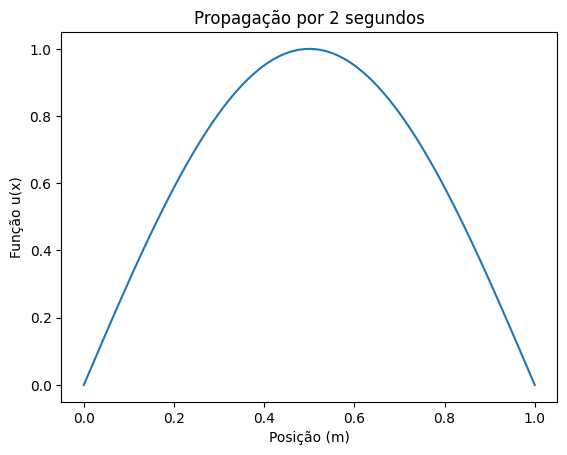

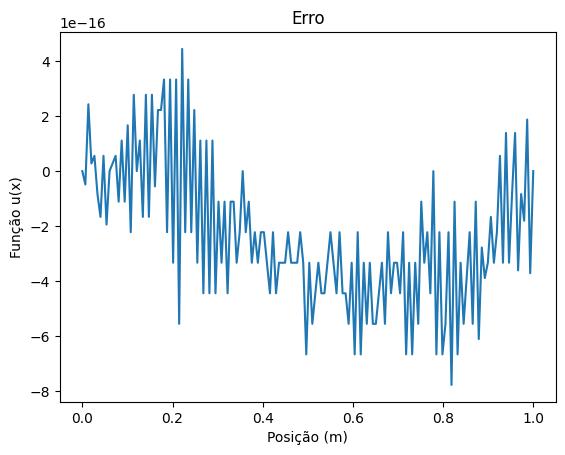

In [72]:
# Fazer a simulação
sol, dt = onda1DvarCTCS(Tmax, fi, gi, mask, qq, dx, save=True)

# Mostrar a solução
plt.plot(xx, sol[-1], label="Resultado")
plt.title(f"Propagação por {dt * (len(sol) - 1):.0f} segundos")
plt.xlabel('Posição (m)')
plt.ylabel('Função u(x)')
plt.show()

# Comparar com a solução exata
plt.plot(xx, sol[-1] - u(xx, dt * (len(sol) - 1)), label="Resultado")
plt.title(f"Erro")
plt.xlabel('Posição (m)')
plt.ylabel('Função u(x)')
plt.show()


# Inicializar o Vídeo!
fig, ax = plt.subplots()
line, = ax.plot(xx, sol[0])
if n == 1:
    ax.set_ylim(-A * 1.04, A * 1.04)


# Velocidade
videoS = 1

# Função de inicialização
def init():
    plt.title(f"Propagação por 0 segundos")
    plt.xlabel('Posição (m)')
    plt.ylabel('Função u(x)')
    line.set_ydata(sol[0])
    return line,

# Função de atualização
def update(frame):
    index =  frame * videoS

    plt.title(f"Propagação por {dt * index:.2f} segundos")
    line.set_ydata(sol[index])
    return line,

# Criar a animação
# ani = animation.FuncAnimation(fig, update, frames=np.arange(0, len(sol) // videoS), init_func=init, blit=True, interval=50)
# ani.save('animation1.gif', writer='ffmpeg', fps=20)
plt.close()

### Método CTCS Descontinuidade

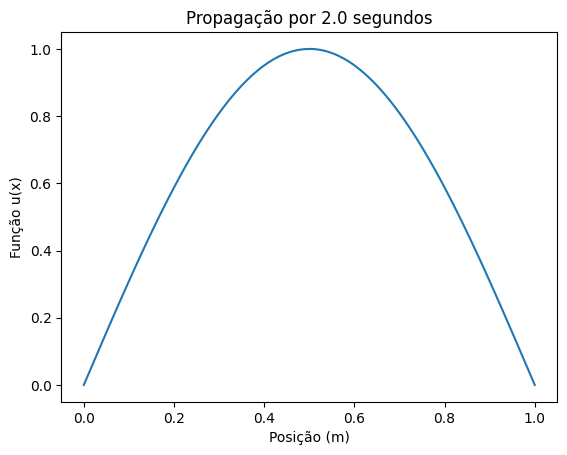

In [73]:
# Fazer a simulação
sol, dt = onda1DquebraCTCS(Tmax, fi, gi, mask, v, v, dx, save=True)

# Mostrar a solução
plt.plot(xx, sol[-1], label="Resultado")
plt.title(f"Propagação por {dt * (len(sol) - 1):.1f} segundos")
plt.xlabel('Posição (m)')
plt.ylabel('Função u(x)')
plt.show()


# Inicializar o Vídeo!
fig, ax = plt.subplots()
line, = ax.plot(xx, sol[0])
ax.set_ylim(-np.max(np.abs(fi)) * 2.04, np.max(np.abs(fi)) * 2.04)

# Velocidade
videoS = 12

# Função de inicialização
def init():
    plt.title(f"Propagação por 0 segundos")
    plt.xlabel('Posição (m)')
    plt.ylabel('Função u(x)')
    line.set_ydata(sol[0])
    return line,

# Função de atualização
def update(frame):
    index =  frame * videoS

    plt.title(f"Propagação por {dt * index:.2f} segundos")
    line.set_ydata(sol[index])
    return line,

# Criar a animação
# ani = animation.FuncAnimation(fig, update, frames=np.arange(0, len(sol) // videoS), init_func=init, blit=True, interval=50)
# ani.save('animation1.gif', writer='ffmpeg', fps=20)
plt.close()

# Experimentar

## Caso 1 - Onda a incidir numa descontinuidade

In [74]:
# Parâmetros
Tmax = 30

Lx = 30

Nx = 600
dx = Lx / (Nx - 1)

# Domínio
xx = np.linspace(-Lx/2, Lx/2, Nx)

# Condições fronteira de extremo fechado
mask = np.full_like(xx, True)
mask[0] = False
mask[-1] = False


# Velocidade muda a meio
q1 = 1
q2 = 4
qq = np.full_like(xx, q1**2)
qq[qq.shape[0]//2:] = q2**2
# qq[qq.shape[0]//2-1:] = 0.25 * q2 + 0.75 * q1
# qq[qq.shape[0]//2:] = 0.5 * q2 + 0.5 * q1
# qq[qq.shape[0]//2+1:] = 0.75 * q2 + 0.25 * q1



# Condição Inicial
df = 1 * Lx/3
def f(x):
    return np.exp(-(x+df)**2)

def fprime(x):
    return np.exp(-(x+df)**2) * (-2 * (x+df))


fi = f(xx)
gi = -v * fprime(xx)

### Método CTCS

Não bate certo com a previsão teórica! [Ver mais](https://www.notion.so/guilhermebaos/7-Ondas-Progressivas-e-a-Equa-o-de-Onda-e3daeaa6bc5b4017bebc953ae0465f71?pvs=4#1e3cec48434546c489e8c592ae52aa9a).

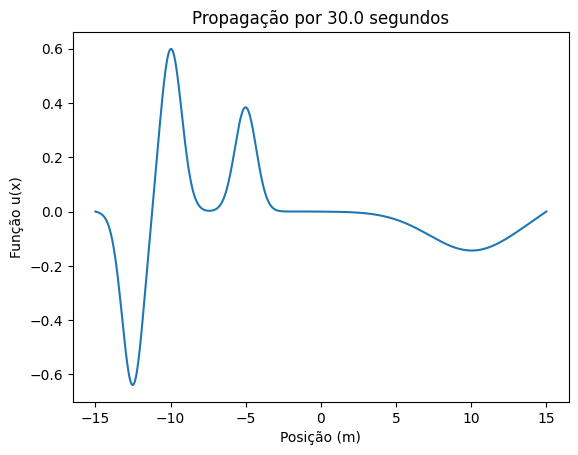

MovieWriter ffmpeg unavailable; using Pillow instead.


In [75]:
# Fazer a simulação
sol, dt = onda1DvarCTCS(Tmax, fi, gi, mask, qq, dx, save=True)

# Mostrar a solução
plt.plot(xx, sol[-1], label="Resultado")
plt.title(f"Propagação por {dt * (len(sol) - 1):.1f} segundos")
plt.xlabel('Posição (m)')
plt.ylabel('Função u(x)')
plt.show()


# Inicializar o Vídeo!
fig, ax = plt.subplots()
line, = ax.plot(xx, sol[0])
ax.set_ylim(-np.max(np.abs(fi)) * 1.04, np.max(np.abs(fi)) * 1.04)

# Velocidade
videoS = 16

# Função de inicialização
def init():
    plt.title(f"Propagação por 0 segundos")
    plt.xlabel('Posição (m)')
    plt.ylabel('Função u(x)')
    line.set_ydata(sol[0])
    return line,

# Função de atualização
def update(frame):
    index =  frame * videoS

    plt.title(f"Propagação por {dt * index:.2f} segundos")
    line.set_ydata(sol[index])
    return line,

# Criar a animação
ani = animation.FuncAnimation(fig, update, frames=np.arange(0, len(sol) // videoS), init_func=init, blit=True, interval=50)
ani.save('animationE1-01.gif', writer='ffmpeg', fps=20)
plt.close()

### Método CTCS Descontinuidade

Bate certo com a previsão teórica! [Ver mais](https://www.notion.so/guilhermebaos/7-Ondas-Progressivas-e-a-Equa-o-de-Onda-e3daeaa6bc5b4017bebc953ae0465f71?pvs=4#1e3cec48434546c489e8c592ae52aa9a).

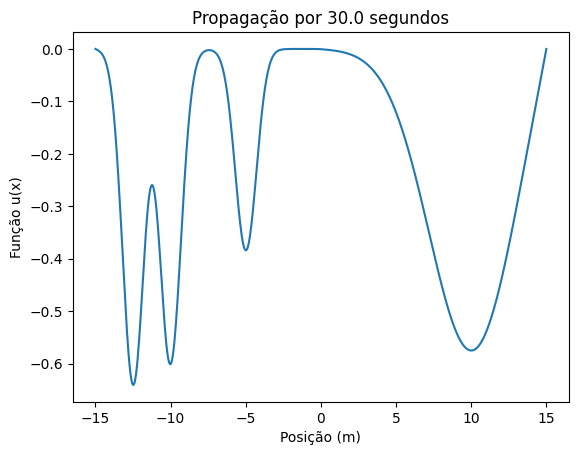

MovieWriter ffmpeg unavailable; using Pillow instead.


In [76]:
# Fazer a simulação
sol, dt = onda1DquebraCTCS(Tmax, fi, gi, mask, q1, q2, dx, save=True)

# Mostrar a solução
plt.plot(xx, sol[-1], label="Resultado")
plt.title(f"Propagação por {dt * (len(sol) - 1):.1f} segundos")
plt.xlabel('Posição (m)')
plt.ylabel('Função u(x)')
plt.show()


# Inicializar o Vídeo!
fig, ax = plt.subplots()
line, = ax.plot(xx, sol[0])
ax.set_ylim(-np.max(np.abs(fi)) * 2.04, np.max(np.abs(fi)) * 2.04)

# Velocidade
videoS = 12

# Função de inicialização
def init():
    plt.title(f"Propagação por 0 segundos")
    plt.xlabel('Posição (m)')
    plt.ylabel('Função u(x)')
    line.set_ydata(sol[0])
    return line,

# Função de atualização
def update(frame):
    index =  frame * videoS

    plt.title(f"Propagação por {dt * index:.2f} segundos")
    line.set_ydata(sol[index])
    return line,

# Criar a animação
ani = animation.FuncAnimation(fig, update, frames=np.arange(0, len(sol) // videoS), init_func=init, blit=True, interval=50)
ani.save('animationE1-02.gif', writer='ffmpeg', fps=20)
plt.close()

## Caso 2 - Oscilação sinusoidal

In [77]:
# Parâmetros
Tmax = 100
Lx = 60

Nx = 600
dx = Lx / (Nx - 1)

# Domínio
xx = np.linspace(-Lx/2, Lx/2, Nx)

# Condições fronteira de extremo fechado
mask = np.full_like(xx, True)
mask[0] = False


# Velocidade muda a meio
q1 = 1
q2 = 4
qq = np.full_like(xx, q1**2)
qq[qq.shape[0]//2:] = q2**2


# Condição Inicial
fi = np.zeros_like(xx)
gi = np.zeros_like(xx)

# Função Força
freq = 0.2
def f(t):
    return np.sin(2 * np.pi * freq * t)

### Método CTCS

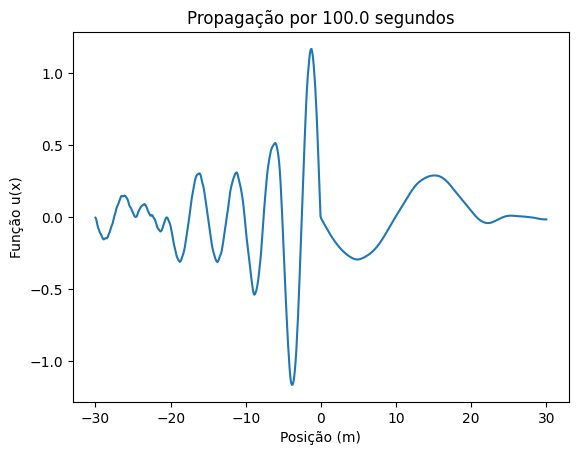

MovieWriter ffmpeg unavailable; using Pillow instead.


In [78]:
# Fazer a simulação
sol, dt = onda1DvarCTCS(Tmax, fi, gi, mask, qq, dx, force = f, save=True)

# Mostrar a solução
plt.plot(xx, sol[-1], label="Resultado")
plt.title(f"Propagação por {dt * (len(sol) - 1):.1f} segundos")
plt.xlabel('Posição (m)')
plt.ylabel('Função u(x)')
plt.show()


# Inicializar o Vídeo!
fig, ax = plt.subplots()
line, = ax.plot(xx, sol[0])
ax.set_ylim(-np.max(np.abs(sol)) * 1.04, np.max(np.abs(sol)) * 1.04)

# Velocidade
videoS = 8

# Função de inicialização
def init():
    plt.title(f"Propagação por 0 segundos")
    plt.xlabel('Posição (m)')
    plt.ylabel('Função u(x)')
    line.set_ydata(sol[0])
    return line,

# Função de atualização
def update(frame):
    index =  frame * videoS

    plt.title(f"Propagação por {dt * index:.2f} segundos")
    line.set_ydata(sol[index])
    return line,

# Criar a animação
ani = animation.FuncAnimation(fig, update, frames=np.arange(0, len(sol) // videoS), init_func=init, blit=True, interval=50)
ani.save('animationE2-01.gif', writer='ffmpeg', fps=20)
plt.close()

### Método CTCS Descontinuidade

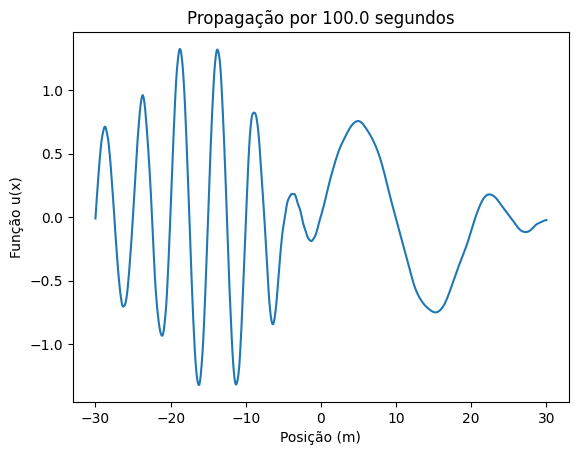

MovieWriter ffmpeg unavailable; using Pillow instead.


In [79]:
# Fazer a simulação
sol, dt = onda1DquebraCTCS(Tmax, fi, gi, mask, q1, q2, dx, force = f, save=True)

# Mostrar a solução
plt.plot(xx, sol[-1], label="Resultado")
plt.title(f"Propagação por {dt * (len(sol) - 1):.1f} segundos")
plt.xlabel('Posição (m)')
plt.ylabel('Função u(x)')
plt.show()


# Inicializar o Vídeo!
fig, ax = plt.subplots()
line, = ax.plot(xx, sol[0])
ax.set_ylim(-np.max(np.abs(sol)) * 1.04, np.max(np.abs(sol)) * 1.04)

# Velocidade
videoS = 12

# Função de inicialização
def init():
    plt.title(f"Propagação por 0 segundos")
    plt.xlabel('Posição (m)')
    plt.ylabel('Função u(x)')
    line.set_ydata(sol[0])
    return line,

# Função de atualização
def update(frame):
    index =  frame * videoS

    plt.title(f"Propagação por {dt * index:.2f} segundos")
    line.set_ydata(sol[index])
    return line,

# Criar a animação
ani = animation.FuncAnimation(fig, update, frames=np.arange(0, len(sol) // videoS), init_func=init, blit=True, interval=50)
ani.save('animationE2-02.gif', writer='ffmpeg', fps=20)
plt.close()